# Multi-Face identification using CNN : Grayscale


 - In this notebook we will build our facial identification model step by step to recognize four people. Note that we have images in **jpg** format, and we will go throw the details on how to prepare the data (X, y) for our CNN model. We add an extra folder where we put images for some people that we don't know to classify them as **unknown**.
 - The model will be trained on images containing faces, what I mean by that is each image contains just the face area. We don't take the background into consideration.
 - If your images are not like that, you have two options:
     - Manually resized them and keep just the face part.
     - Use <a href="https://docs.opencv.org/3.4/db/d28/tutorial_cascade_classifier.html">face cascade classifier</a> to extract the face part from each image and save them. If the face cascade classifier miss some faces, then you will manually resize them. 

 - The model will run on real-time, for each video frame, we will first extract the faces using face cascade and then make predictions. For each face in an image we make prediction.
 
First let's import some libraries :

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import pickle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from random import randrange, uniform
from time import time
import glob
import shutil
import itertools
from time import time

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline


# Image size
IMG_SIZE = 38

# Dataset folder
DATADIR = "dataset"

# Five classes/folders
CATEGORIES = ["aljadd", "nossaiba", "nouhaila", "langze", "unknown"]

# Create trainning, validation and test sets

In [6]:
os.chdir('dataset')
if os.path.isdir('train/aljadd') is False:
    for category in CATEGORIES:
        # Make train/category
        os.makedirs(f'train/{category}')
        
        # Make test/category
        os.makedirs(f'test/{category}')
        
        # Make valid/category
        os.makedirs(f'valid/{category}')

        
    for category in CATEGORIES:
        print(category)
        
        # Randomly take 400 images for training
        for c in random.sample(glob.glob(f'{category}/{category}*'), 450):
            shutil.move(c, f'train/{category}')

        # Randomly take 70 images for validation
        for c in random.sample(glob.glob(f'{category}/{category}*'), 50):
            shutil.move(c, f'valid/{category}')

        # Move the rest to test folder
        for img in os.listdir(f'{category}/'):
            image = f'{category}/{img}'
            shutil.move(image, f'test/{category}')

aljadd
nossaiba
nouhaila
langze
unknown


**Move back images if necessary**

In [7]:
# Were are still in dataset folder
#os.chdir('dataset')
def reset(): # Move every images back to initial folder
    three_folders = ["train", "test", "valid"]
    for category in CATEGORIES:
        for folder in three_folders:
            for img in os.listdir(f'{folder}/{category}'):
                image = fr'{folder}/{category}/{img}'
                shutil.move(image, f'{category}')
#reset()

In [8]:
!pwd

/cygdrive/c/Users/install.PO-ETU007/Desktop/MyProjects/iEars/Model training/Face identification/dataset


In [9]:
os.chdir("../")

In [10]:
!pwd

/cygdrive/c/Users/install.PO-ETU007/Desktop/MyProjects/iEars/Model training/Face identification


# Data preprocessing

## 1- Create arrays of grayscale images

In [11]:
train = []
valid = []
test = []
sets = ["train", "valid", "test"]
data = [train, valid, test]

for s in range(0, 3):
    
    # Path to train, valid or test
    path = os.path.join("dataset", sets[s])
    
    for category in CATEGORIES:
        
        # index of the class: 0, ... 4
        class_num = CATEGORIES.index(category)
        
        # Path to a category inside a set : eg. train/mohammed
        full_path = os.path.join(path, category)
        for img in tqdm(os.listdir(full_path)):
            
            img_path = os.path.join(full_path,img)
            
            # grayscale
            img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img_resized = cv2.resize(img_gray, (IMG_SIZE, IMG_SIZE))
            
            # Add data to the three sets
            data[s].append([img_resized, class_num]) 

100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 200.84it/s]


In [12]:
random.shuffle(train)
random.shuffle(valid)
random.shuffle(test)

In [13]:
# Make arrays

X_train = []
y_train = []

X_valid = []
y_valid = []

X_test = []
y_test = []

data = [train, valid, test]

# Train
for features,label in train:
    X_train.append(features)
    y_train.append(label)
X_train = np.array(X_train).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_train = np.array(y_train)

# Valid
for features,label in valid:
    X_valid.append(features)
    y_valid.append(label)
X_valid = np.array(X_valid).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_valid = np.array(y_valid)

# Test
for features,label in test:
    X_test.append(features)
    y_test.append(label)
X_test = np.array(X_test).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_test = np.array(y_test)

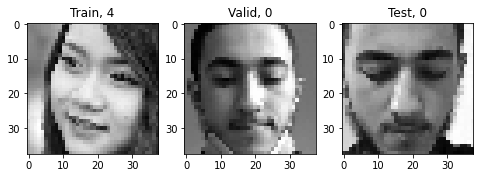

In [14]:
# Let's plot one image from each set

# random indexs
i1 = random.randrange(0, len(X_train))
i2 = random.randrange(0, len(X_valid))
i3 = random.randrange(0, len(X_test))

w = 10
h = 10
fig = plt.figure(figsize=(8, 8))
columns = 3
rows = 1
fig.add_subplot(rows, columns, 1)
plt.imshow(X_train[i1], cmap="gray")
plt.title(f"Train, {y_train[i1]}")
fig.add_subplot(rows, columns, 2)
plt.imshow(X_valid[i2], cmap="gray")
plt.title(f"Valid, {y_valid[i2]}")
fig.add_subplot(rows, columns, 3)
plt.imshow(X_test[i3], cmap="gray")
plt.title(f"Test, {y_test[i3]}")
plt.show()

## 2- One hot encoding

- This is very important to understand. In binary classification the y outputs takes two values (0, 1) but, in our case we have five values because class_num vary from 0 to 4. 
 - y is :
$$y = \begin{bmatrix}0\\
1\\
2\\
3\\
4\\
\end{bmatrix}$$

- Our CNN model accept only one hot format which is :
$$y_{one-hot} = \begin{bmatrix}1 & 0 & 0 & 0 & 0\\
0 & 1 & 0 & 0 & 0\\
0 & 0 & 1 & 0 & 0\\
0 & 0 & 0 & 1 & 0\\
0 & 0 & 0 & 0 & 1\\
\end{bmatrix}$$

- Let's convert y to one hot format be using **to_categorical**:

In [15]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_valid = to_categorical(y_valid)

## 3- Data augmentation for training set

   - **Data augmentation** in a technique used to increase the amount of data by adding slightly modified copies of already existing data or newly created synthetic data from existing data.
   - Do not add soo much noise so that the model underfit the data.
   - We will use <a href="https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator">ImageDataGenerator</a> from tensorflow.

In [16]:
gen = ImageDataGenerator(
        # Rotate images by 40°
        rotation_range = 30,
        width_shift_range = 1,
        height_shift_range = 1,
        # shearing the image 
        shear_range = 1,
        channel_shift_range = 25,
        brightness_range = (0.95, 1.5),
        zoom_range = 0.1,
        horizontal_flip = True,
        # The area left after rotationg image will be filled with same color on image
        fill_mode='nearest')

# This is for generating cropped images
def crop(image, padding=3):
    p = padding
    w, h, _ = image.shape
    cropped_image = image[p:w-p, p:h-p]
    cropped_image = cv2.resize(cropped_image, (IMG_SIZE, IMG_SIZE))
    cropped_image = cropped_image.reshape(IMG_SIZE, IMG_SIZE, 1)
    return cropped_image

# This is for image blurring
def blur(image, kernel_size=(2, 2)):
    image_blurred = cv2.blur(image, kernel_size) 
    image_blurred = cv2.resize(image_blurred, (IMG_SIZE, IMG_SIZE))
    image_blurred = image_blurred.reshape(IMG_SIZE, IMG_SIZE, 1)
    return image_blurred

In [17]:
# Display for each image the new generated image
def show(img1, img2, img3, index):
    w = 10
    h = 10
    fig = plt.figure(figsize=(8, 8))
    columns = 3
    rows = 1
    fig.add_subplot(rows, columns, 1)
    plt.imshow(img1, cmap="gray")
    plt.title(f'Original {index}')
    
    fig.add_subplot(rows, columns, 2)
    plt.imshow(img2, cmap="gray")
    plt.title(f'Cropped {index}')
    
    fig.add_subplot(rows, columns, 3)
    plt.imshow(img3, cmap="gray")
    plt.title(f'Generated {index}')
    plt.show()

In [19]:
# Number of generated images for each original image:
l = 12

j = 1
index = 0
data_aug = []
for img in X_train:
    img_expanded = np.expand_dims(img,0)
    
    # Original image
    data_aug.append([img, y_train[index]])
    
    # Cropped image
    cropped = crop(image=img, padding=3)
    data_aug.append([cropped, y_train[index]])
    
    # Image blurring
    blurred = blur(image=img, kernel_size=(2, 2))
    data_aug.append([blurred, y_train[index]])
    
    # ImageDataGenerator
    aug_iter = gen.flow(img_expanded)
    aug_images = [next(aug_iter)[0].astype(np.uint8) for i in range(l)]
    
    for image in aug_images:
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        image = image.reshape((IMG_SIZE, IMG_SIZE, 1))
        data_aug.append([image, y_train[index]])
        # Show original image and the new created image. This is just to see is things are going well. 
        # Uncomment the following line of code if you want.
        # show(img, cropped, image, y_train[index])
        j += 1
    print(f"Image number {j} out of {(l+1)*len(X_train)}", end='\r')
    index += 1

In [20]:
# Add the new data to X_train
X_train = []
y_train = []

for features,label in data_aug:
    X_train.append(features)
    y_train.append(label)

X_train = np.array(X_train)
y_train = np.array(y_train)

# Normalizing for fast computation (Backpropagation)

X_train = tf.keras.utils.normalize(X_train, axis=1)
X_valid = tf.keras.utils.normalize(X_valid, axis=1)
X_test = tf.keras.utils.normalize(X_test, axis=1)

# Save data in pickle

In [21]:
# I created a folder name data.pickle to save my data in
pickle_out = open("data.pickle/X_train.pickle","wb")
pickle.dump(X_train, pickle_out)
pickle_out.close()

pickle_out = open("data.pickle/y_train.pickle","wb")
pickle.dump(y_train, pickle_out)
pickle_out.close()

pickle_out = open("data.pickle/X_valid.pickle","wb")
pickle.dump(X_valid, pickle_out)
pickle_out.close()

pickle_out = open("data.pickle/y_valid.pickle","wb")
pickle.dump(y_valid, pickle_out)
pickle_out.close()

pickle_out = open("data.pickle/X_test.pickle","wb")
pickle.dump(X_test, pickle_out)
pickle_out.close()

pickle_out = open("data.pickle/y_test.pickle","wb")
pickle.dump(y_test, pickle_out)
pickle_out.close()

# Load data

In [22]:
pickle_in = open("data.pickle/X_train.pickle","rb")
X_train = pickle.load(pickle_in)

pickle_in = open("data.pickle/y_train.pickle","rb")
y_train = pickle.load(pickle_in)

pickle_in = open("data.pickle/X_valid.pickle","rb")
X_valid = pickle.load(pickle_in)

pickle_in = open("data.pickle/y_valid.pickle","rb")
y_valid = pickle.load(pickle_in)


pickle_in = open("data.pickle/X_test.pickle","rb")
X_test = pickle.load(pickle_in)

pickle_in = open("data.pickle/y_test.pickle","rb")
y_test = pickle.load(pickle_in)

In [23]:
X_train.shape, y_train.shape

((33750, 38, 38, 1), (33750, 5))

### Build the CNN model

In [24]:
model = Sequential()

model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
model.add(Dropout(0.5))

model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
model.add(Dropout(0.5))

model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
model.add(Dropout(0.5))

#model.add(Conv2D(16, kernel_size=3, activation='relu'))
##model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.5))

#model.add(Conv2D(32, kernel_size=3, activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.5))

model.add(Flatten())

# I have five classes
model.add(Dense(5, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 36, 36, 32)        320       
                                                                 
 dropout (Dropout)           (None, 36, 36, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 dropout_1 (Dropout)         (None, 34, 34, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 dropout_2 (Dropout)         (None, 32, 32, 32)        0         
                                                                 
 flatten (Flatten)           (None, 32768)             0

### Train the model

 - Epochs are number of passes on the entire dataset. The model will pass 5 times on the dataset. In each epoch, it will takes 20 images (batch_size)

In [26]:
model.fit(X_train, y_train, batch_size=25, epochs=5, validation_data=(X_valid, y_valid))

Epoch 1/5
1350/1350 [==============================] - 147s 108ms/step - loss: 0.2052 - accuracy: 0.8109 - val_loss: 0.0709 - val_accuracy: 0.9800
Epoch 2/5
1350/1350 [==============================] - 150s 111ms/step - loss: 0.0923 - accuracy: 0.9411 - val_loss: 0.0387 - val_accuracy: 0.9880
Epoch 3/5
1350/1350 [==============================] - 150s 111ms/step - loss: 0.0643 - accuracy: 0.9632 - val_loss: 0.0273 - val_accuracy: 0.9920
Epoch 4/5
1350/1350 [==============================] - 156s 115ms/step - loss: 0.0510 - accuracy: 0.9726 - val_loss: 0.0194 - val_accuracy: 0.9880
Epoch 5/5
1350/1350 [==============================] - 156s 116ms/step - loss: 0.0431 - accuracy: 0.9785 - val_loss: 0.0217 - val_accuracy: 0.9960


### Evaluate the model on the test set

In [27]:
model.evaluate(X_test, y_test)

30/30 [==============================] - 1s 16ms/step - loss: 0.0787 - accuracy: 0.9479


[0.07874848693609238, 0.9478623270988464]

In [28]:
def predict_from_X(threshold):
    sample = X_test[random.randrange(0, len(X_test))]
    image = np.expand_dims(sample, axis=0)
    prediction = model.predict(image)
    index = np.argmax(prediction[0])
    probabilty = float(format(max(prediction[0]*100), ".3f"))
    plt.imshow(sample)
    title = ""
    if probabilty < threshold*100:
        title = "Unknown p<threshold"
    else:
        title = f"{CATEGORIES[index]} {probabilty}%"
    
    plt.title(title)
    plt.show()

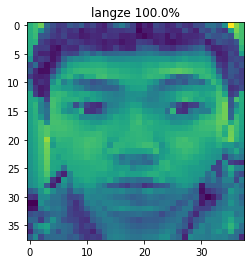

In [29]:
predict_from_X(threshold=0.6)

### Save the model in h5 format

 - Always save !!!

In [30]:
#model.save("model_h5_format/model.h5")
model.save("model_h5_format/cnn_big_model.h5")

### Load the model

In [31]:
#model = load_model("model_h5_format/model.h5")
model = load_model("model_h5_format/cnn_big_model.h5") 

## Real time test

In [3]:
# Make prediction from image (jpg format ...):
def predict_from_frame(image, threshold):
    image = tf.keras.utils.normalize(image)
    image = np.expand_dims(image, axis=0)
    prediction = model.predict(image)
    index = np.argmax(prediction[0])
    probabilty = float(format(max(prediction[0]*100), ".3f"))
    
    if probabilty < threshold*100:
        title = "Unknown 'p<threshold'"
    else:
        title = f"{CATEGORIES[index]} {probabilty}%"
        
    return title

In [4]:
cap = cv2.VideoCapture(0)
font = cv2.FONT_HERSHEY_SIMPLEX
last_time = time()
face_cascade = cv2.CascadeClassifier("cascades/data/haarcascade_frontalface_default.xml")


while True:
    ret, frame = cap.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=2, minNeighbors=1)
    for (x, y, w, h) in faces:
        roi = gray[y:y+h, x:x+w]
    
        resized_roi = cv2.resize(roi, (IMG_SIZE, IMG_SIZE))
    
        color = (255, 0, 0) 
        stroke = 2
        end_cord_x = x + w
        end_cord_y = y + h 
        cv2.rectangle(frame, (x, y), (end_cord_x, end_cord_y), color, stroke)

        p = predict_from_frame(resized_roi, threshold=0.0)   
        cv2.putText(frame, p , (x,y), font, 1, (0, 0, 255), 1,1)


          
    cv2.imshow('Video', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
cap.release()
cv2.destroyAllWindows()

In [27]:
cap = cv2.VideoCapture(0)
font = cv2.FONT_HERSHEY_SIMPLEX
last_time = time()
face_cascade = cv2.CascadeClassifier("cascades/data/haarcascade_frontalface_default.xml")


while True:
    ret, frame = cap.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.5, minNeighbors=1)
    if len(faces) != 0:
        for (x, y, w, h) in faces:
            roi = gray[y:y+h, x:x+w]

            resized_roi = cv2.resize(roi, (IMG_SIZE, IMG_SIZE))

            color = (255, 0, 0) 
            stroke = 2
            end_cord_x = x + w
            end_cord_y = y + h 
            cv2.rectangle(frame, (x, y), (end_cord_x, end_cord_y), color, stroke)

            p = predict_from_frame(resized_roi, threshold=0.0)   
            cv2.putText(frame, p , (x,y), font, 1, (0, 0, 255), 1,1)

    else:
        cv2.putText(frame, "No face is detected" , (x,y), font, 1, (0, 0, 255), 1,1)
    
    cv2.imshow('Video', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
cap.release()
cv2.destroyAllWindows()

NameError: name 'predict_from_frame' is not defined

In [ ]:
if len(faces) != 0:
        for (x, y, w, h) in faces:
            roi = gray[y:y+h, x:x+w]

            resized_roi = cv2.resize(roi, (IMG_SIZE, IMG_SIZE))

            color = (255, 0, 0) 
            stroke = 2
            end_cord_x = x + w
            end_cord_y = y + h 
            cv2.rectangle(frame, (x, y), (end_cord_x, end_cord_y), color, stroke)

            p = predict_from_frame(resized_roi, threshold=0.0)   
            cv2.putText(frame, p , (x,y), font, 1, (0, 0, 255), 1,1)

    else:
        cv2.putText(frame, "No face is detected" , (x,y), font, 1, (0, 0, 255), 1,1)

In [21]:
CATEGORIES = ["aljadd", "nossaiba", "nouhaila", "langze", "unknown", "no person"]

In [22]:
predictions = [1, 2, 1, 2, 4, 3, 5, 2, 4, 5, 3, 2, 3, 3, 5, 2, 4, 5, 3, 2, 3, 5, 5]
predictions

[1, 2, 1, 2, 4, 3, 5, 2, 4, 5, 3, 2, 3, 3, 5, 2, 4, 5, 3, 2, 3, 5, 5]

In [23]:
predictions_no_duplicates = []
for i in predictions :
    if i not in predictions_no_duplicates:
        predictions_no_duplicates.append(i)
predictions_no_duplicates

[1, 2, 4, 3, 5]

In [24]:
occurences = []
for p in predictions_no_duplicates:
    occurence = predictions.count(p)
    # Do not consider duplicates of faces of known people, because it's due to face cascade errors
    if p not in [0, 1, 2, 3]:
        occurences.append(occurence)
    else:
        occurences.append(1)
occurences

[1, 1, 3, 1, 6]

In [25]:
f"Predicitions : {predictions_no_duplicates}, Occurences : {occurences}"

'Predicitions : [1, 2, 4, 3, 5], Occurences : [1, 1, 3, 1, 6]'

In [26]:
# Index of "no person is detected"
index_no_person = predictions_no_duplicates.index(5)
predictions_no_duplicates.pop(index_no_person)
occurences.pop(index_no_person)

6

In [17]:
predictions_no_duplicates.pop(index_no_person)
occurences.pop(index_no_person)

6

In [18]:
f"Predicitions : {predictions_no_duplicates}, Occurences : {occurences}"

'Predicitions : [1, 2, 4, 3], Occurences : [1, 1, 3, 1]'

In [147]:
number_of_faces = len(predictions_no_duplicates)
predictions = predictions_no_duplicates

In [148]:
def replace(i):
            if i == 1:
                return ""
            else:
                return str(i)

result = "Il y a "
if number_of_faces == 1:
    result += f"{replace(occurences[0])}{CATEGORIES[predictions[0]]}"

elif number_of_faces == 2:
    result += f"{replace(occurences[0])} {CATEGORIES[predictions[0]]} et {replace(occurences[1])} {CATEGORIES[predictions[1]]}"

else:
    i = 0
    for p in predictions_no_duplicates:
        if i < number_of_faces-1:
            result += f"{replace(occurences[i])} {CATEGORIES[p]}, "
        else:
            result += f"et {replace(occurences[i])} {CATEGORIES[p]}."
        i += 1
result

'Il y a  nossaiba,  nouhaila, 3 unknown,  langze, et 6 no person.'

In [104]:
number_of_faces

5